In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import os
from collections import Counter
from torchvision import models
from torch.utils.tensorboard import SummaryWriter
from torchvision.datasets import ImageFolder
from torchvision import transforms
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import pandas as pd
import warnings

In [31]:
data_dir = '/Users/franciszeklasinski/Desktop/Projekty Github/car-vs-bike/Car-Bike-Dataset'
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

dataset = datasets.ImageFolder(data_dir, transform=transform)
loader = DataLoader(dataset, batch_size=16, shuffle=True)

class_names = dataset.classes
print("Klasy:", class_names)
print("Liczba próbek w zbiorze:", len(dataset))

Klasy: ['Bike', 'Car']
Liczba próbek w zbiorze: 3999


In [32]:
# Podział danych na train/validation
from torch.utils.data import random_split

# Podział: 80% train, 20% validation
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2)

print(f"Zbiór treningowy: {len(train_dataset)} próbek")
print(f"Zbiór walidacyjny: {len(val_dataset)} próbek")

Zbiór treningowy: 3199 próbek
Zbiór walidacyjny: 800 próbek


In [33]:
# Dodatkowe transformacje dla lepszej augmentacji
enhanced_transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.1),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.9, 1.1)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) 
])

# Osobny transform dla walidacji (bez augmentacji)
val_transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])


Przykładowe zdjęcia:


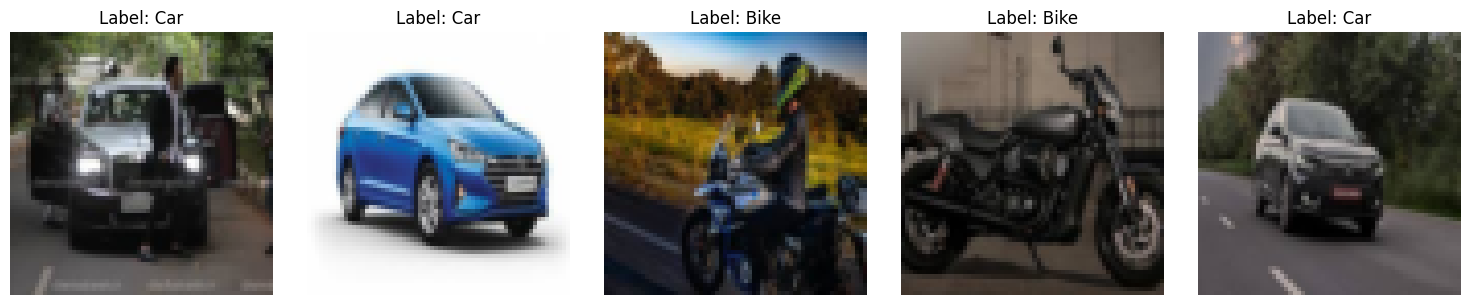

In [34]:
def imshow(img, title=None):
    img = img / 2 + 0.5  # denormalizacja
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    if title:
        plt.title(title)
    plt.show()

plain_transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

plain_dataset = ImageFolder(data_dir, transform=plain_transform)
plain_loader = DataLoader(plain_dataset, batch_size=16, shuffle=True)

dataiter = iter(plain_loader)
images, labels = next(dataiter)

print("Przykładowe zdjęcia:")
fig, axes = plt.subplots(1, 5, figsize=(15, 3))
for i in range(5):
    img = images[i] / 2 + 0.5  
    npimg = img.numpy()
    axes[i].imshow(np.transpose(npimg, (1, 2, 0)))
    axes[i].set_title(f"Label: {class_names[labels[i]]}")
    axes[i].axis('off')
plt.tight_layout()
plt.show()

In [35]:
class ImprovedModel(nn.Module):
    def __init__(self, num_classes=2):
        super(ImprovedModel, self).__init__()
        
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout2d(0.25),
            
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout2d(0.25),
            
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout2d(0.3),
        
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.AdaptiveAvgPool2d((4, 4))
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(512 * 4 * 4, 1024),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(1024, 256),
            nn.ReLU(inplace=True),
            nn.Dropout(0.3),
            nn.Linear(256, num_classes)
        )
    
    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x



In [36]:
# Funkcja testująca
def test(model, loader, loss_fn, device):
    model.eval()
    running_loss, correct, total = 0.0, 0, 0
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = loss_fn(outputs, labels)
            running_loss += loss.item() * images.size(0)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    avg_loss = running_loss / total
    avg_acc = correct / total
    return avg_loss, avg_acc

In [ ]:
device = torch.device('mps' if torch.backends.mps.is_available() else 'cuda' if torch.cuda.is_available() else 'cpu')
print(f"Używane urządzenie: {device}")

# Inicjalizacja modelu i optymalizatora
model = ImprovedModel().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-4)

# Learning rate scheduler
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)

# Tensorboard
writer = SummaryWriter("runs/car_bike_improved")

# Early stopping
class EarlyStopping:
    def __init__(self, patience=10, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = float('inf')
    
    def __call__(self, val_loss):
        if val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
            return False
        else:
            self.counter += 1
            return self.counter >= self.patience

early_stopping = EarlyStopping(patience=5)

# Trening
epochs = 30
train_losses, val_losses = [], []
train_accs, val_accs = [], []
best_val_acc = 0.0

for epoch in range(epochs):
    # Faza treningowa
    model.train()
    running_loss, correct, total = 0.0, 0, 0
    
    for batch_idx, (images, labels) in enumerate(train_loader):
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * images.size(0)
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)
    
    train_loss = running_loss / total
    train_acc = correct / total
    
    # Faza walidacyjna
    val_loss, val_acc = test(model, val_loader, criterion, device)
    
    # Scheduler step
    scheduler.step(val_loss)
    
    # najlepszy model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), 'best_car_bike_model.pth')
    
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accs.append(train_acc)
    val_accs.append(val_acc)
    
    writer.add_scalar('Loss/Train', train_loss, epoch)
    writer.add_scalar('Loss/Validation', val_loss, epoch)
    writer.add_scalar('Accuracy/Train', train_acc, epoch)
    writer.add_scalar('Accuracy/Validation', val_acc, epoch)
    
    print(f"Epoka {epoch+1}/{epochs} | "
          f"Train Loss: {train_loss:.4f}, Acc: {train_acc:.4f} | "
          f"Val Loss: {val_loss:.4f}, Acc: {val_acc:.4f}")
    
    # Early stopping
    if early_stopping(val_loss):
        print(f"Early stopping na epoce {epoch+1}")
        break

writer.close()
print(f"\nNajlepsza accuracy walidacyjna: {best_val_acc:.4f}")


Używane urządzenie: mps
Rozpoczynam trening...


/Users/franciszeklasinski/Library/Python/3.9/lib/python/site-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/Users/franciszeklasinski/Library/Python/3.9/lib/python/site-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/Users/franciszeklasinski/Library/Python/3.9/lib/python/site-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoka 1/30 | Train Loss: 0.7172, Acc: 0.5814 | Val Loss: 0.9897, Acc: 0.5650


/Users/franciszeklasinski/Library/Python/3.9/lib/python/site-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/Users/franciszeklasinski/Library/Python/3.9/lib/python/site-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/Users/franciszeklasinski/Library/Python/3.9/lib/python/site-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoka 2/30 | Train Loss: 0.4895, Acc: 0.7774 | Val Loss: 0.3816, Acc: 0.8387


/Users/franciszeklasinski/Library/Python/3.9/lib/python/site-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/Users/franciszeklasinski/Library/Python/3.9/lib/python/site-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/Users/franciszeklasinski/Library/Python/3.9/lib/python/site-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoka 3/30 | Train Loss: 0.3643, Acc: 0.8506 | Val Loss: 0.2897, Acc: 0.8675


/Users/franciszeklasinski/Library/Python/3.9/lib/python/site-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/Users/franciszeklasinski/Library/Python/3.9/lib/python/site-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/Users/franciszeklasinski/Library/Python/3.9/lib/python/site-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoka 4/30 | Train Loss: 0.2963, Acc: 0.8856 | Val Loss: 0.2016, Acc: 0.9225


/Users/franciszeklasinski/Library/Python/3.9/lib/python/site-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/Users/franciszeklasinski/Library/Python/3.9/lib/python/site-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/Users/franciszeklasinski/Library/Python/3.9/lib/python/site-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoka 5/30 | Train Loss: 0.2681, Acc: 0.8962 | Val Loss: 0.3114, Acc: 0.8662


/Users/franciszeklasinski/Library/Python/3.9/lib/python/site-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/Users/franciszeklasinski/Library/Python/3.9/lib/python/site-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/Users/franciszeklasinski/Library/Python/3.9/lib/python/site-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoka 6/30 | Train Loss: 0.2345, Acc: 0.9078 | Val Loss: 0.2463, Acc: 0.9062


/Users/franciszeklasinski/Library/Python/3.9/lib/python/site-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/Users/franciszeklasinski/Library/Python/3.9/lib/python/site-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/Users/franciszeklasinski/Library/Python/3.9/lib/python/site-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoka 7/30 | Train Loss: 0.2258, Acc: 0.9125 | Val Loss: 0.1903, Acc: 0.9225


/Users/franciszeklasinski/Library/Python/3.9/lib/python/site-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/Users/franciszeklasinski/Library/Python/3.9/lib/python/site-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/Users/franciszeklasinski/Library/Python/3.9/lib/python/site-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoka 8/30 | Train Loss: 0.1961, Acc: 0.9250 | Val Loss: 0.2137, Acc: 0.9150


/Users/franciszeklasinski/Library/Python/3.9/lib/python/site-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/Users/franciszeklasinski/Library/Python/3.9/lib/python/site-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/Users/franciszeklasinski/Library/Python/3.9/lib/python/site-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoka 9/30 | Train Loss: 0.1799, Acc: 0.9306 | Val Loss: 0.1840, Acc: 0.9263


/Users/franciszeklasinski/Library/Python/3.9/lib/python/site-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/Users/franciszeklasinski/Library/Python/3.9/lib/python/site-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/Users/franciszeklasinski/Library/Python/3.9/lib/python/site-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoka 10/30 | Train Loss: 0.2030, Acc: 0.9244 | Val Loss: 0.1724, Acc: 0.9287


/Users/franciszeklasinski/Library/Python/3.9/lib/python/site-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/Users/franciszeklasinski/Library/Python/3.9/lib/python/site-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/Users/franciszeklasinski/Library/Python/3.9/lib/python/site-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoka 11/30 | Train Loss: 0.1664, Acc: 0.9406 | Val Loss: 0.1595, Acc: 0.9375


/Users/franciszeklasinski/Library/Python/3.9/lib/python/site-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/Users/franciszeklasinski/Library/Python/3.9/lib/python/site-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/Users/franciszeklasinski/Library/Python/3.9/lib/python/site-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoka 12/30 | Train Loss: 0.1511, Acc: 0.9419 | Val Loss: 0.1731, Acc: 0.9350


/Users/franciszeklasinski/Library/Python/3.9/lib/python/site-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/Users/franciszeklasinski/Library/Python/3.9/lib/python/site-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/Users/franciszeklasinski/Library/Python/3.9/lib/python/site-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoka 13/30 | Train Loss: 0.1432, Acc: 0.9484 | Val Loss: 0.1563, Acc: 0.9375


/Users/franciszeklasinski/Library/Python/3.9/lib/python/site-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/Users/franciszeklasinski/Library/Python/3.9/lib/python/site-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/Users/franciszeklasinski/Library/Python/3.9/lib/python/site-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoka 14/30 | Train Loss: 0.1556, Acc: 0.9444 | Val Loss: 0.1853, Acc: 0.9275


/Users/franciszeklasinski/Library/Python/3.9/lib/python/site-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/Users/franciszeklasinski/Library/Python/3.9/lib/python/site-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/Users/franciszeklasinski/Library/Python/3.9/lib/python/site-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoka 15/30 | Train Loss: 0.1535, Acc: 0.9462 | Val Loss: 0.1519, Acc: 0.9463


/Users/franciszeklasinski/Library/Python/3.9/lib/python/site-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/Users/franciszeklasinski/Library/Python/3.9/lib/python/site-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/Users/franciszeklasinski/Library/Python/3.9/lib/python/site-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoka 16/30 | Train Loss: 0.1405, Acc: 0.9506 | Val Loss: 0.1587, Acc: 0.9387


/Users/franciszeklasinski/Library/Python/3.9/lib/python/site-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/Users/franciszeklasinski/Library/Python/3.9/lib/python/site-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/Users/franciszeklasinski/Library/Python/3.9/lib/python/site-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoka 17/30 | Train Loss: 0.1289, Acc: 0.9540 | Val Loss: 0.1232, Acc: 0.9513


/Users/franciszeklasinski/Library/Python/3.9/lib/python/site-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/Users/franciszeklasinski/Library/Python/3.9/lib/python/site-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/Users/franciszeklasinski/Library/Python/3.9/lib/python/site-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoka 18/30 | Train Loss: 0.1223, Acc: 0.9540 | Val Loss: 0.1452, Acc: 0.9525


/Users/franciszeklasinski/Library/Python/3.9/lib/python/site-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/Users/franciszeklasinski/Library/Python/3.9/lib/python/site-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/Users/franciszeklasinski/Library/Python/3.9/lib/python/site-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoka 19/30 | Train Loss: 0.1167, Acc: 0.9584 | Val Loss: 0.1369, Acc: 0.9525


/Users/franciszeklasinski/Library/Python/3.9/lib/python/site-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/Users/franciszeklasinski/Library/Python/3.9/lib/python/site-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/Users/franciszeklasinski/Library/Python/3.9/lib/python/site-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoka 20/30 | Train Loss: 0.1269, Acc: 0.9547 | Val Loss: 0.1443, Acc: 0.9587


/Users/franciszeklasinski/Library/Python/3.9/lib/python/site-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/Users/franciszeklasinski/Library/Python/3.9/lib/python/site-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/Users/franciszeklasinski/Library/Python/3.9/lib/python/site-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoka 21/30 | Train Loss: 0.1246, Acc: 0.9525 | Val Loss: 0.1694, Acc: 0.9425


/Users/franciszeklasinski/Library/Python/3.9/lib/python/site-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/Users/franciszeklasinski/Library/Python/3.9/lib/python/site-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/Users/franciszeklasinski/Library/Python/3.9/lib/python/site-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoka 22/30 | Train Loss: 0.1109, Acc: 0.9594 | Val Loss: 0.1471, Acc: 0.9363
Early stopping na epoce 22

Najlepsza accuracy walidacyjna: 0.9587


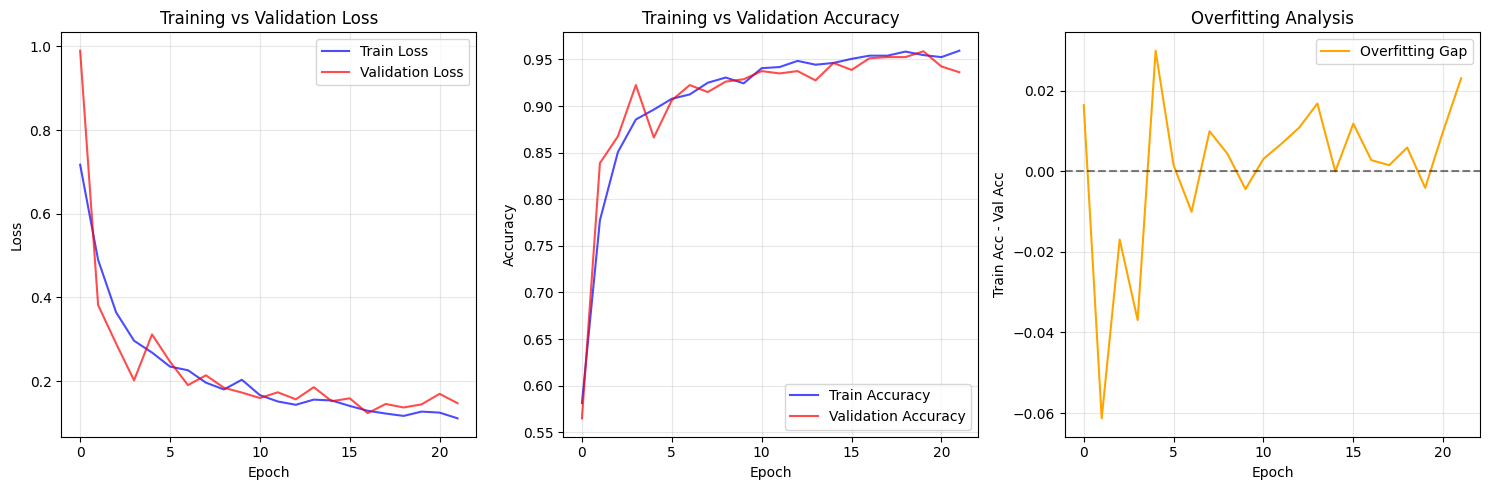


Podsumowanie wyników:
Najlepsza accuracy walidacyjna: 95.88%
Najlepsza accuracy treningowa: 95.94%
Najniższy loss walidacyjny: 0.1232
Ostatnia epoka - Val Acc: 93.62%, Val Loss: 0.1471
Overfitting gap (ostatnia epoka): 2.31%
Stabilność modelu (std z ostatnich 10 epok): 0.0091


In [38]:
plt.figure(figsize=(15, 5))

# Loss plot
plt.subplot(1, 3, 1)
plt.plot(train_losses, label='Train Loss', color='blue', alpha=0.7)
plt.plot(val_losses, label='Validation Loss', color='red', alpha=0.7)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.grid(True, alpha=0.3)

# Accuracy plot
plt.subplot(1, 3, 2)
plt.plot(train_accs, label='Train Accuracy', color='blue', alpha=0.7)
plt.plot(val_accs, label='Validation Accuracy', color='red', alpha=0.7)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training vs Validation Accuracy')
plt.legend()
plt.grid(True, alpha=0.3)

# Learning curve
plt.subplot(1, 3, 3)
plt.plot(np.array(train_accs) - np.array(val_accs), label='Overfitting Gap', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Train Acc - Val Acc')
plt.title('Overfitting Analysis')
plt.legend()
plt.grid(True, alpha=0.3)
plt.axhline(y=0, color='black', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()
# Podsumowanie wyników
print("\nPodsumowanie wyników:")
print(f"Najlepsza accuracy walidacyjna: {max(val_accs)*100:.2f}%")
print(f"Najlepsza accuracy treningowa: {max(train_accs)*100:.2f}%")
print(f"Najniższy loss walidacyjny: {min(val_losses):.4f}")
print(f"Ostatnia epoka - Val Acc: {val_accs[-1]*100:.2f}%, Val Loss: {val_losses[-1]:.4f}")
print(f"Overfitting gap (ostatnia epoka): {(train_accs[-1] - val_accs[-1])*100:.2f}%")

# Analiza stabilności
val_acc_std = np.std(val_accs[-10:])  # Odchylenie z ostatnich 10 epok
print(f"Stabilność modelu (std z ostatnich 10 epok): {val_acc_std:.4f}")


/Users/franciszeklasinski/Library/Python/3.9/lib/python/site-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/Users/franciszeklasinski/Library/Python/3.9/lib/python/site-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/Users/franciszeklasinski/Library/Python/3.9/lib/python/site-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/Users/franciszeklasinski/Library/Python/3.9/lib/python/site-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/Users/franciszeklasinski/Library/Python/3.9/lib/python/site-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to

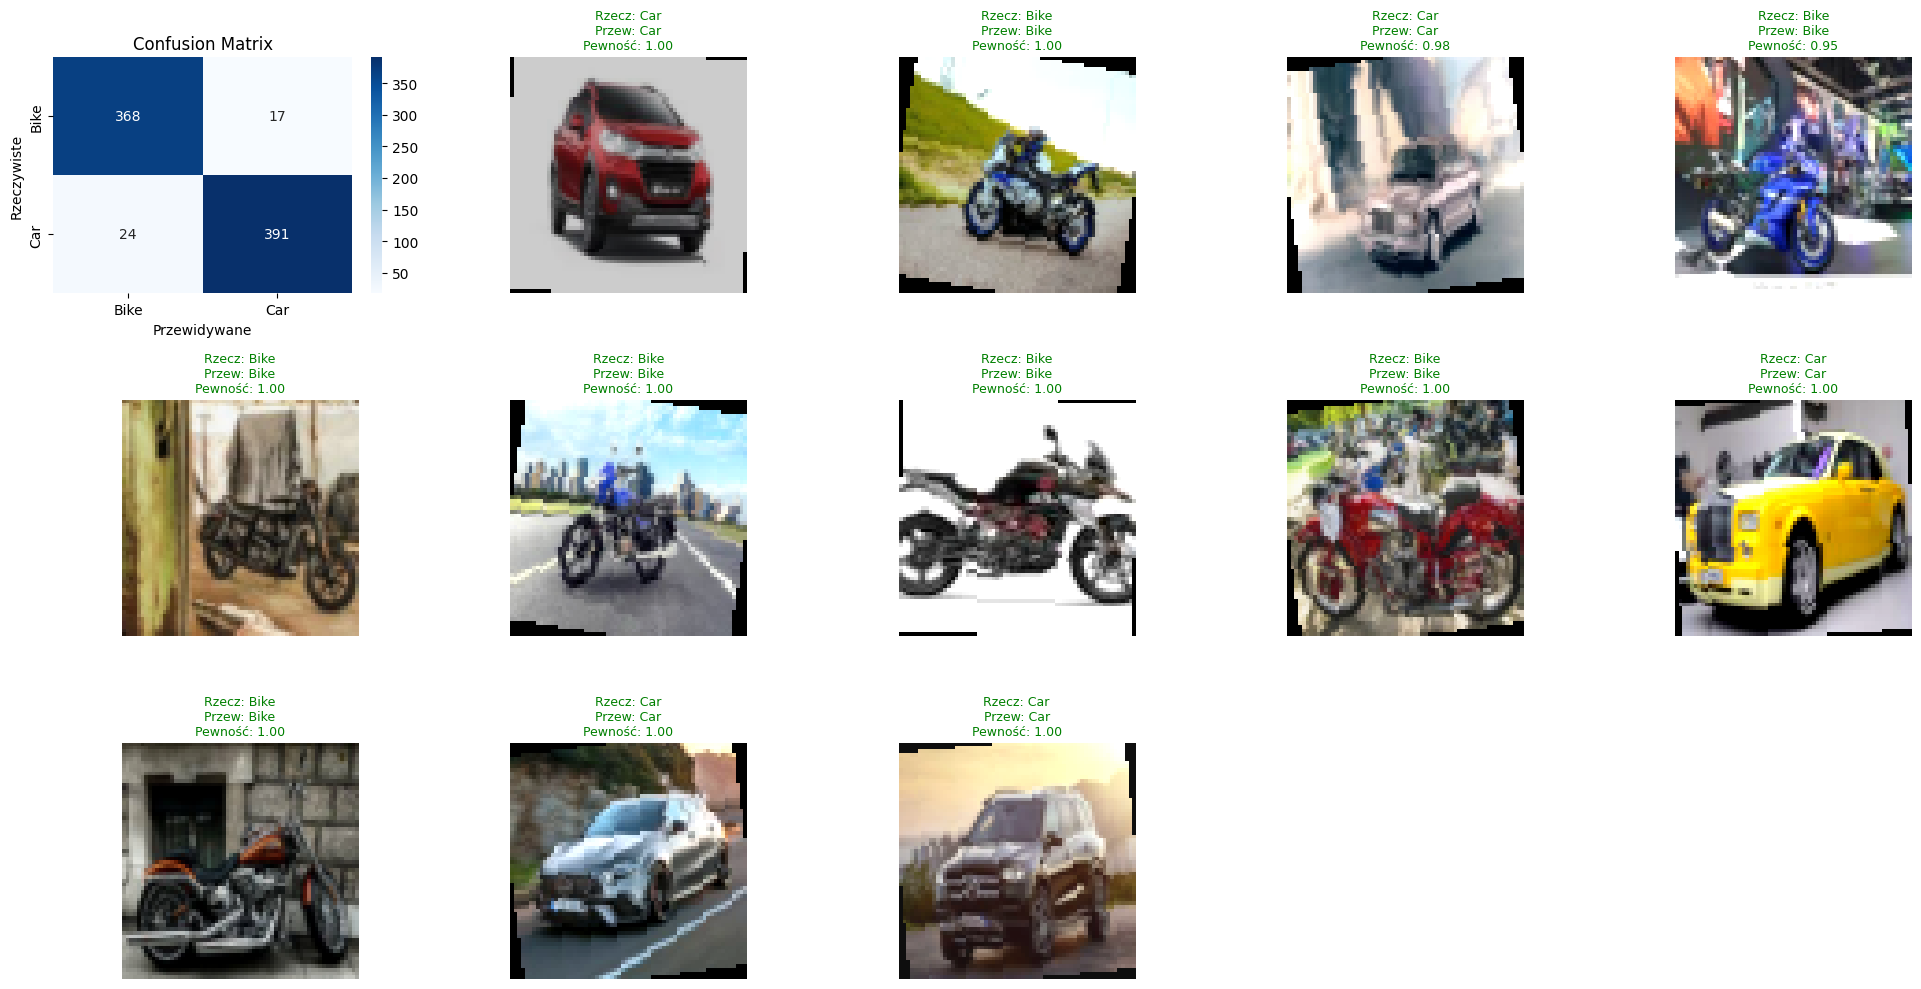

=== RAPORT KLASYFIKACJI ===
              precision    recall  f1-score   support

        Bike       0.94      0.96      0.95       385
         Car       0.96      0.94      0.95       415

    accuracy                           0.95       800
   macro avg       0.95      0.95      0.95       800
weighted avg       0.95      0.95      0.95       800

Accuracy dla klasy 'Bike': 95.58%
Accuracy dla klasy 'Car': 94.22%

Ogólna accuracy na zbiorze walidacyjnym: 94.88%


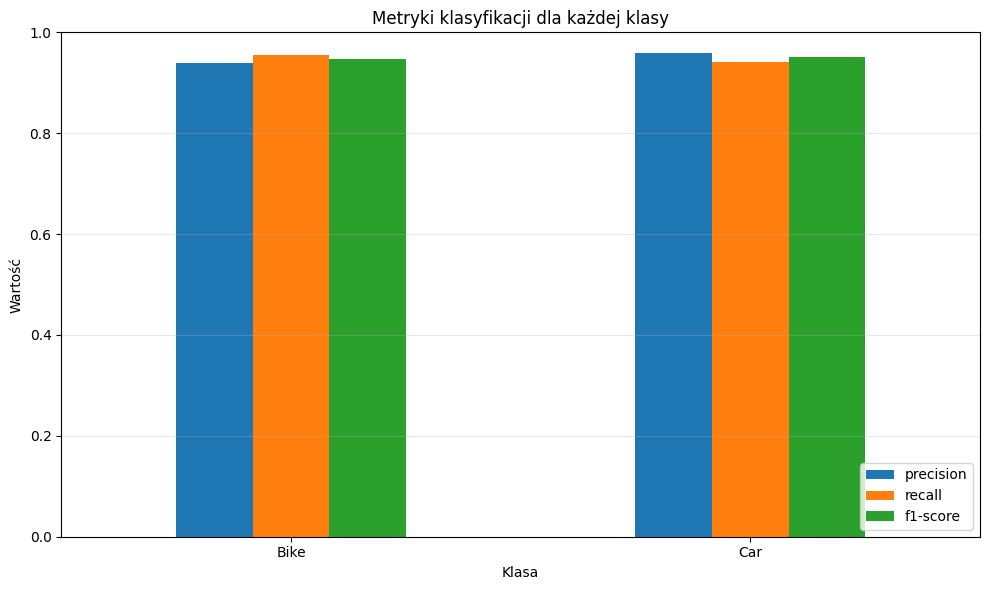

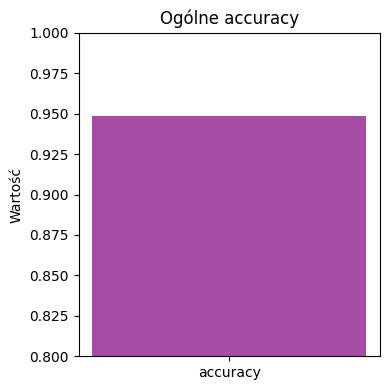

In [44]:
# Ładowanie najlepszego modelu
model.load_state_dict(torch.load('best_car_bike_model.pth'))
model.eval()

# Funkcja do predykcji z pewnością
def predict_with_confidence(model, image_tensor, device):
    model.eval()
    with torch.no_grad():
        image_tensor = image_tensor.unsqueeze(0).to(device)
        outputs = model(image_tensor)
        probabilities = torch.softmax(outputs, dim=1)
        confidence, predicted = torch.max(probabilities, 1)
        return predicted.item(), confidence.item()

# Testowanie na przykładowych obrazach
plt.figure(figsize=(20, 10))
dataiter = iter(val_loader)
images, labels = next(dataiter)

# Predykcje dla batch'a
all_preds = []
all_labels = []

with torch.no_grad():
    for imgs, lbls in val_loader:
        imgs = imgs.to(device)
        outputs = model(imgs)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(lbls.numpy())

# Confusion Matrix
plt.subplot(3, 5, 1)
cm = confusion_matrix(all_labels, all_preds)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.ylabel('Rzeczywiste')
plt.xlabel('Przewidywane')

# Przykładowe predykcje
for i in range(12):
    plt.subplot(3, 5, i+2)
    img = images[i]
    pred_class, confidence = predict_with_confidence(model, img, device)
    img_display = img / 2 + 0.5
    npimg = img_display.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    
    actual_class = class_names[labels[i]]
    pred_class_name = class_names[pred_class]
    color = 'green' if pred_class == labels[i] else 'red'
    
    plt.title(f'Rzecz: {actual_class}\nPrzew: {pred_class_name}\nPewność: {confidence:.2f}', 
              color=color, fontsize=9)
    plt.axis('off')

plt.tight_layout()
plt.show()

print("=== RAPORT KLASYFIKACJI ===")
report = classification_report(all_labels, all_preds, target_names=class_names, output_dict=True)
print(classification_report(all_labels, all_preds, target_names=class_names))

# Accuracy dla każdej klasy
for i, class_name in enumerate(class_names):
    class_mask = np.array(all_labels) == i
    class_acc = np.mean(np.array(all_preds)[class_mask] == np.array(all_labels)[class_mask])
    print(f"Accuracy dla klasy '{class_name}': {class_acc*100:.2f}%")

print(f"\nOgólna accuracy na zbiorze walidacyjnym: {np.mean(np.array(all_preds) == np.array(all_labels))*100:.2f}%")

#Wykresy
metrics = ['precision', 'recall', 'f1-score']
report_df = pd.DataFrame(report).T
class_metrics = report_df.loc[class_names, metrics]

plt.figure(figsize=(10, 6))
class_metrics.plot(kind='bar', ylim=(0, 1), rot=0, ax=plt.gca())
plt.title('Metryki klasyfikacji dla każdej klasy')
plt.ylabel('Wartość')
plt.xlabel('Klasa')
plt.legend(loc='lower right')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

# Ogólne accuracy
plt.figure(figsize=(4, 4))
plt.bar(['accuracy'], [report['accuracy']], color='purple', alpha=0.7)
plt.ylim(0.8, 1)
plt.title('Ogólne accuracy')
plt.ylabel('Wartość')
plt.tight_layout()
plt.show()